In [1]:
# стандартные импорты
import numpy as np
import math as m
import matplotlib.pyplot as plt
import timeit

plt.rc('font', size=20)

In [2]:
class AbstractFemSolver:
    
    def __init__(self, mesh, function):
        self.mesh = mesh
        self.f = function
        self.numNodes = len(self.mesh.nodes)
        self.BasisFuncs = [BasisFunction(self.mesh, i) \
                            for i in range(0, self.numNodes)]
        
    def SetupLinearSystem(self):
        self.M = np.zeros((self.numNodes, self.numNodes))
        self.b = np.zeros(self.numNodes)
        
        for i in range(self.numNodes):
           # вычисление элементов матрицы масс
            for j in range(self.numNodes):
                self.M[i, j] = self.MassMatrixEntry(i, j)
    
           # вычисление элементов вектора нагрузки
            self.b[i] = self.LoadVectorEntry(i)
            
    def MassMatrixEntry(self, i, j):
        raise NotImplementedError()
        
    def LoadVectorEntry(self, i):
        raise NotImplementedError()
        
    def Solve(self):
        self.SetupLinearSystem()
        self.c = np.linalg.solve(self.M, self.b)
        
    def EvaluateSolution(self, x):
        value = 0.
        for coeff, BasisFunc in zip(self.c, self.BasisFuncs):
            value += coeff*BasisFunc(x)
        return value
    
    def PlotSolution(self):
        xL = self.mesh.nodes[0]
        xR = self.mesh.nodes[-1]
        
        self.xData = np.linspace(xL, xR, 100)
        yData = np.array([self.EvaluateSolution(x) for x in self.xData])
        
        #plt.figure(figsize=(11, 6))
        plt.plot(self.xData, yData, '-', lw=2, label=self.__class__.__name__)
        plt.legend()
        plt.grid(None)
        #plt.show()

In [3]:
class FEMSolverRegression(AbstractFemSolver):
     
    def __init__(self, mesh, function, points):
        AbstractFemSolver.__init__(self, mesh, function)
        self.regressionPoints = points
        
    def MassMatrixEntry(self, i, j):
        points = self.regressionPoints
        value = 0.
        for k in range(len(points)):
            value += self.BasisFuncs[i](points[k])*self.BasisFuncs[j](points[k])
        
        return value
    
    def LoadVectorEntry(self, i):
        points = self.regressionPoints
        value = 0.
        for k in range(len(points)):
            value += self.BasisFuncs[i](points[k])*self.f(points[k])
        
        return value
        

In [4]:
class FEMMesh:
    
    def __init__(self, xL, xR, numFEs):
        # равноотстоящие узлы
        self.numFEs = numFEs
        self.nodes = list(np.linspace(xL, xR, numFEs + 1))
        self.finiteElems = [ [self.nodes[i], self.nodes[i + 1]] \
                             for i in range(len(self.nodes) - 1)] 
        self.h = float(np.diff(self.nodes)[0])
    
    
    def __str__(self):
        counter = 0
        for elem in self.finiteElems:
            print('Elem #%d: [%.2f, %.2f]' % (counter, elem.xL, elem.xR))
            counter += 1

In [5]:
class BasisFunction:
    
    # индекс "i" базисной функции: 1 <= i <= numNodes - 2
    def __init__(self, mesh, index):
        self.mesh = mesh
        self.i = index # "i" --- параметр
    
    def __call__(self, x):
        xArrayMesh = self.mesh.nodes # для краткости
        i = self.i # для краткости
        
        # функция-"шапка"
        if i != 0 and i != len(xArrayMesh) - 1:
            if x >= xArrayMesh[i - 1] and x < xArrayMesh[i]:
                return (x - xArrayMesh[i - 1]) / self.mesh.h
            elif x >= xArrayMesh[i] and x < xArrayMesh[i + 1]:
                return 1. - (x - xArrayMesh[i]) / self.mesh.h
            else:
                return 0.
            

        # левая функция-"полушапка"
        elif i == 0:
            if x >= xArrayMesh[0] and x < xArrayMesh[1]:
                return 1. - (x - xArrayMesh[i]) / self.mesh.h
            else: 
                return 0.
        
        
        # правая функция-"полушапка"
        elif i == len(xArrayMesh) - 1:
            if x > xArrayMesh[-2] and x <= xArrayMesh[-1]:
                return (x - xArrayMesh[-2]) / self.mesh.h
            else: 
                return 0.
            
    
    def Plot(self):
        xL = self.mesh.nodes[0]
        xR = self.mesh.nodes[-1]
        
        xData = np.linspace(xL, xR, 100)
        yData = np.array([self(x) for x in xData])
        
        plt.figure(figsize=(11, 6))
        plt.plot(xData, yData, '-', lw=2)
        plt.grid(None)
        plt.show()

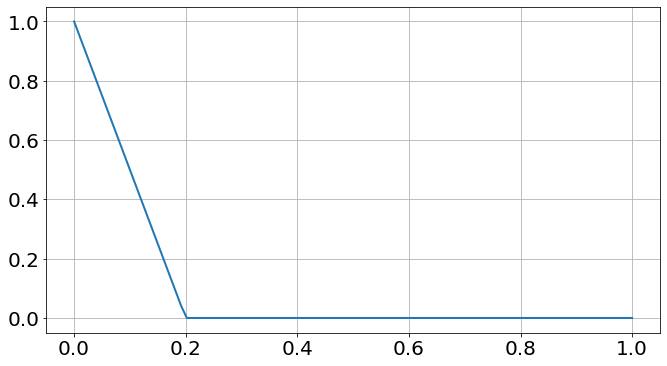

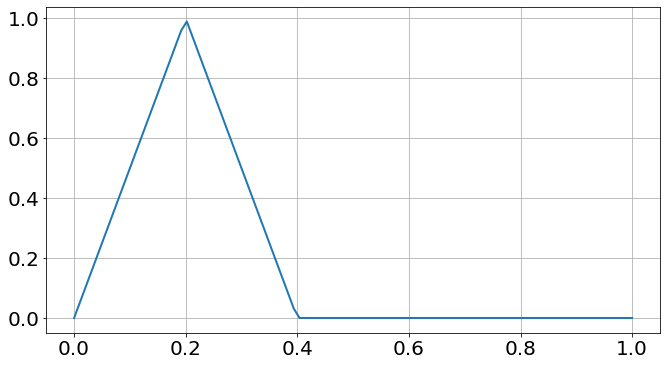

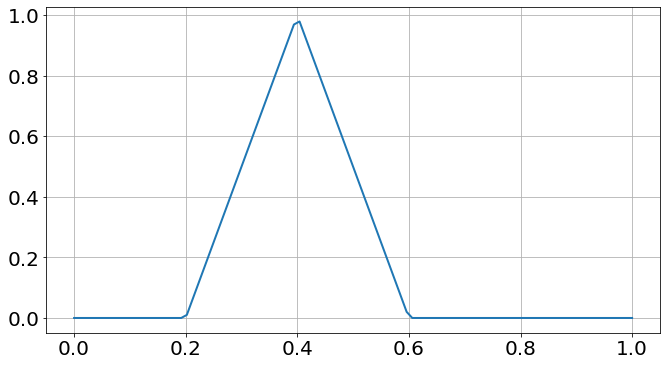

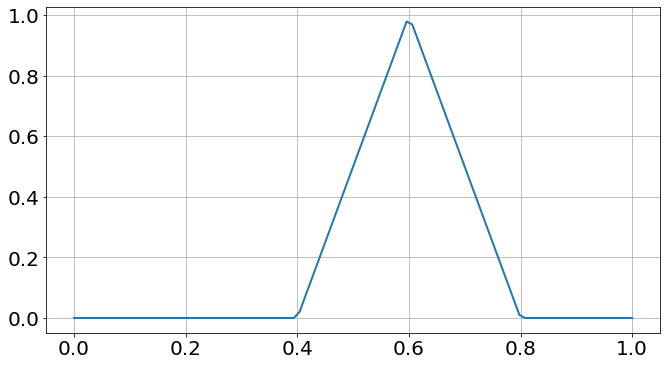

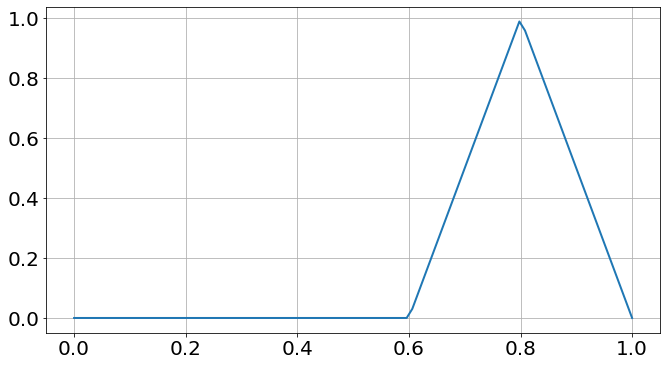

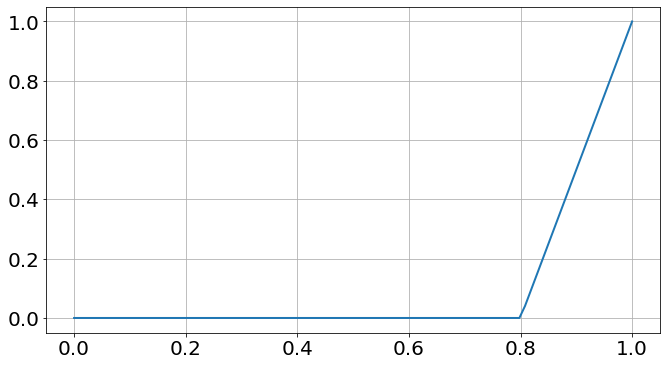

In [6]:
# построение графиков базисных функций
mesh1 = FEMMesh(xL=0., xR=1., numFEs=5)

for i in range(mesh1.numFEs + 1):
    f = BasisFunction(mesh=mesh1, index=i)
    f.Plot()

In [7]:
# удобней хранить в парах, чтобы не использоввать zip в цикле for
class SolverPair:
    
    def __init__(self, methodClass, points):
        self.methodClass = methodClass
        self.points = points

In [8]:
# использование
testFunc = lambda t: 1. + (t**2)*np.sin(2.*m.pi*t)

xL_, xR_ = 0., 1.
mesh = FEMMesh(xL=xL_, xR=xR_, numFEs=5)
regressionPoints = np.linspace(xL_, xR_, 40)

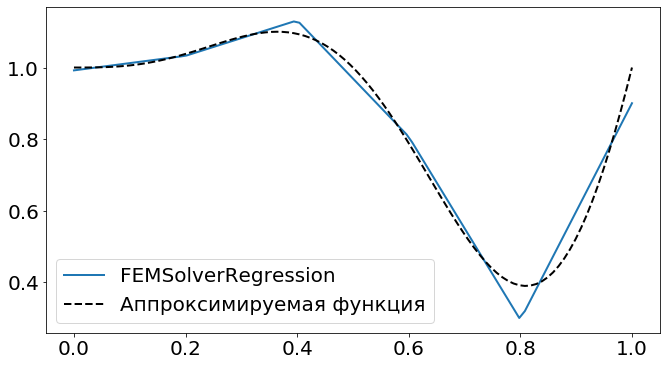

In [9]:
solverRegression = SolverPair(FEMSolverRegression, regressionPoints)

# вместо списка можно использовать словарь (список с доступом по ключу)
solversClass = [solverRegression]

plt.figure(figsize=(11, 6))
for solverClass in solversClass:
    solver = solverClass.methodClass(mesh, testFunc, solverClass.points)
    solver.Solve()
    solver.PlotSolution()

# график аппроксимируемой функции
plt.plot(solver.xData, testFunc(solver.xData), 'k--', label='Аппроксимируемая функция', lw=2)
plt.legend(loc='best')
plt.grid(None)
plt.show()

In [10]:
class AbstractIntegral:
    
        
    def SetFunction(self, function):
        self.function = function
    
    def SetLeftBorder(self, leftBorder):
        self.leftBorder = leftBorder
        
    def SetNumBlocks(self, n):
        self.n = n
        
    def SetCoefficients(self, points):
        raise NotImplementedError
    
    def __call__(self, x):
        self.gridArray = np.linspace(self.leftBorder, x, self.n + 1) 
        self.gridLength = len(self.gridArray)
        step = np.diff(self.gridArray)[0]
        
        self.SetCoefficients(self.gridLength)
        
        f, left, right, coeffs = self.function, self.leftBorder, x, self.coefficients    
        
        fValues = [f(t) for t in self.gridArray]
        value = np.dot(coeffs, fValues)#fValues)
        value *= step
        
        return value
    
    
class TrapezoidalIntegral(AbstractIntegral):
    
    def SetCoefficients(self, points):
        self.coefficients = [0.5] + [1] * (points - 2) + [0.5]

In [11]:
class FEMSolverLeastSquares(AbstractFemSolver):
    
    def MassMatrixEntry(self, i, j):
        integrationMethod = TrapezoidalIntegral()
        integrationMethod.SetLeftBorder(self.mesh.nodes[0])
        integrationMethod.SetNumBlocks(int(1e2))
        integrationMethod.SetFunction(\
                            lambda t: self.BasisFuncs[i](t)*self.BasisFuncs[j](t) \
                                    )
        return integrationMethod(self.mesh.nodes[-1])
    
    def LoadVectorEntry(self, i):
        integrationMethod = TrapezoidalIntegral()
        integrationMethod.SetLeftBorder(self.mesh.nodes[0])
        integrationMethod.SetNumBlocks(int(1e2))
        integrationMethod.SetFunction(lambda t: self.f(t)*self.BasisFuncs[i](t))
        
        return integrationMethod(self.mesh.nodes[-1])

In [12]:
class FEMSolverInterpolation(AbstractFemSolver):
        
    def __init__(self, mesh, function, interpolationPoints):
        AbstractFemSolver.__init__(self, mesh, function)
        self.interpolationPoints = interpolationPoints
        
        
    def MassMatrixEntry(self, i, j):
        return self.BasisFuncs[j](self.interpolationPoints[i])
    
    def LoadVectorEntry(self, i):
        return self.f(self.interpolationPoints[i])

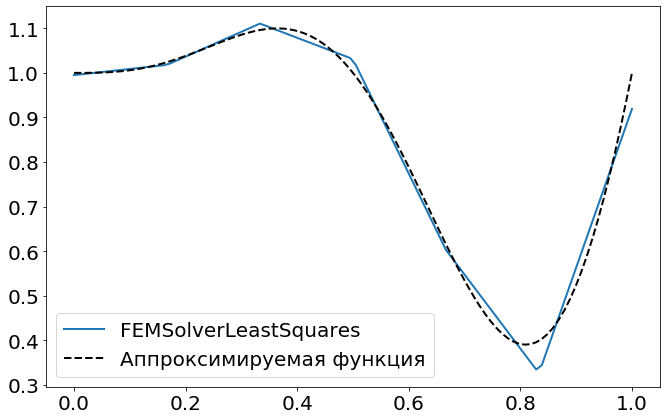

In [13]:
# тестирование
mesh2 = FEMMesh(xL=0., xR=1., numFEs=6)

solver1 = FEMSolverLeastSquares(mesh2, testFunc)
solver1.Solve()
plt.figure(figsize=(11, 7))
solver1.PlotSolution()


plt.plot(solver.xData, testFunc(solver.xData), 'k--', label='Аппроксимируемая функция', lw=2)
plt.legend(loc='best')
plt.grid(None)
plt.show()
    
    
    
    

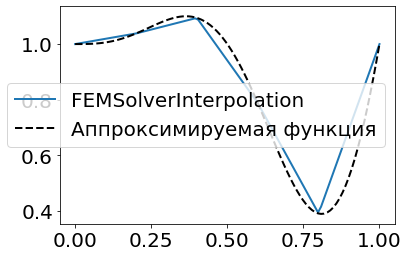

In [14]:

mesh3 = FEMMesh(xL=0., xR=1., numFEs=5)
interpolationPoints1 = np.linspace(0., 1., 6)

solver2 = FEMSolverInterpolation(mesh3, testFunc, interpolationPoints1)  
solver2.Solve()

solver2.PlotSolution()


plt.plot(solver.xData, testFunc(solver.xData), 'k--', label='Аппроксимируемая функция', lw=2)
plt.legend(loc='best')
plt.grid(None)
plt.show()

    

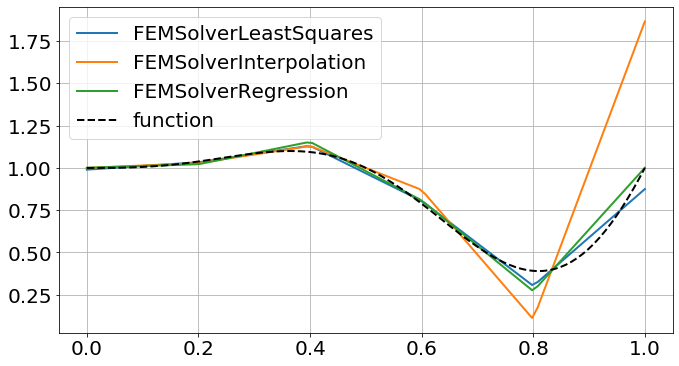

In [16]:
regressionPoints = np.linspace(0., 1., 7)
interpolPoints = mesh2.nodes
solvers = [FEMSolverLeastSquares(mesh3, testFunc), FEMSolverInterpolation(mesh3, testFunc, interpolPoints), \
               FEMSolverRegression(mesh3, testFunc, regressionPoints)]

plt.figure(figsize=(11, 6))
for solver in solvers:
    solver.Solve()
    


xData = np.linspace(0., 1., 100)
for solver in solvers:
      plt.plot(xData, [solver.EvaluateSolution(x) for x in xData], '-', \
               label=solver.__class__.__name__, lw=2)

plt.plot(xData, testFunc(xData), 'k--', label='function', lw=2)
plt.grid('on')
plt.legend()
plt.show()